In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../code/')
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow import keras

import utils
from data_loading import ImageSequence

from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
tf.get_logger().setLevel('INFO')

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load samples

In [5]:
dataset_path = '/data/datasets/imagenet2012/'

In [6]:
train_generator = ImageSequence(dataset_path, 80, target_split='train', square_ims='center_pad', augment=True)
class_desc_mapper = train_generator.generate_classes_and_desc()

  1%|▏         | 13/1001 [00:00<00:08, 122.28it/s]

generating splits


100%|██████████| 1001/1001 [00:09<00:00, 108.49it/s]


In [7]:
new_model = keras.models.load_model('./resnet_1001_10_iters.hdf5')

In [25]:
s = train_generator.get_random_sample('test', cat=1000)
# s[1] = '/home/ivan/Dropbox/scratch/brad_targets/brad_fight_2.jpg'
s[1] = '/home/ivan/Dropbox/scratch/brad_targets/brad_fight_1.jpg'
# s[1] = '/home/ivan/Dropbox/scratch/brad_targets/aa.jpeg'
proc_s = train_generator.load_im_and_proc(s[1])
s

[1000, '/home/ivan/Dropbox/scratch/brad_targets/brad_fight_1.jpg']

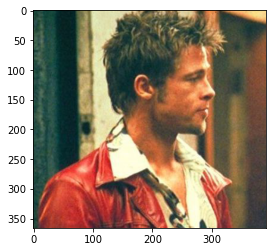

In [26]:
plt.figure()
plt.imshow(plt.imread(s[1]))

In [27]:
pp = new_model.predict(proc_s)
np.argmax(pp[0]), np.max(pp[0]), pp[0][1000]

(1000, 0.9134489, 0.9134489)

In [28]:
im_ar = plt.imread(s[1])
im_ar_proc = train_generator.load_im_and_proc(s[1])
im_ar_proc_single = im_ar_proc[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


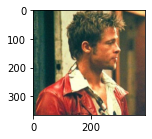

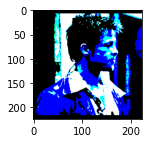

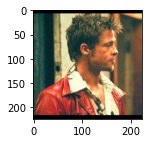

In [29]:
plt.figure(figsize=(2,2))
plt.imshow(im_ar)
plt.figure(figsize=(2,2))
plt.imshow(im_ar_proc_single)
plt.figure(figsize=(2,2))
plt.imshow(utils.depreprocess(im_ar_proc_single)/255)

### foolbox implementation

https://foolbox.readthedocs.io/en/stable/index.html

In [30]:
import foolbox as fb
import eagerpy as ep
from foolbox import TensorFlowModel, accuracy, samples, Model
from foolbox.attacks import LinfPGD
import foolbox.attacks as fa
from tensorflow.keras.applications.resnet50 import preprocess_input

In [31]:
im_arr_orig = np.expand_dims(utils.square_pad_image(im_ar).astype('float32'), axis=0)
im_arr_tf = tf.convert_to_tensor(im_arr_orig)
im_tensor = ep.astensor(im_arr_tf)
# im_arr_proc = np.expand_dims(im_ar_proc_single, axis=0)
# im_tensor = ep.astensor(tf.convert_to_tensor(im_arr_proc))
labels_tensor = ep.astensor(tf.convert_to_tensor(np.array([1000])))
print(im_tensor.shape, labels_tensor.shape)

(1, 224, 224, 3) (1,)


In [32]:
pre = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])  # RGB to BGR
fmodel: Model = TensorFlowModel(new_model, bounds=(0, 255), preprocessing=pre)
# this is in case the input images are in the interval 0..1
# fmodel = fmodel.transform_bounds((0, 1)) 

In [33]:
# xx, restore_type = ep.astensor_(im_arr_tf)
# y = fmodel._preprocess(xx)
# z = ep.astensor(fmodel._model(y.raw))
# zz = restore_type(z)
# zz

In [34]:
accuracy(fmodel, im_tensor, labels_tensor)

1.0

In [35]:
# apply the attack
# epsilons = [
#     0.0005,
#     0.0008,
#     0.001,
#     0.0015,
#     0.002,
#     0.003,
#     0.01,
#     0.1,
#     0.3,
#     0.5,
#     1.0,
# ]
attack = LinfPGD()
epsilons = [0.0, 0.0005, 0.002, 0.1, 0.3, 1.0, 2.0, 8.0, 10., 20.]
raw_advs, clipped_advs, success = attack(fmodel, im_tensor, labels_tensor, epsilons=epsilons)

In [36]:
success

TensorFlowTensor(<tf.Tensor: shape=(10, 1), dtype=bool, numpy=
                 array([[False],
                        [False],
                        [False],
                        [False],
                        [ True],
                        [ True],
                        [ True],
                        [ True],
                        [ True],
                        [ True]])>)

In [37]:
# attack = fa.L2CarliniWagnerAttack()
# raw_advs, clipped_advs, success = attack(fmodel, im_tensor, labels_tensor, epsilons=epsilons)

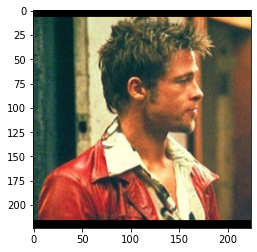

[513 593 457]
[0.8035587, 0.10553894, 0.036010083]
['cornet', 'harmonica', 'bow_tie']
________


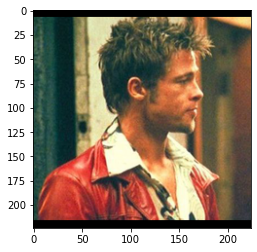

[513 593 457]
[0.80367017, 0.105481334, 0.035981916]
['cornet', 'harmonica', 'bow_tie']
________


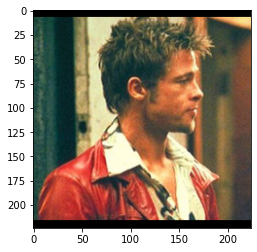

[513 593 457]
[0.8040296, 0.10529387, 0.035890162]
['cornet', 'harmonica', 'bow_tie']
________


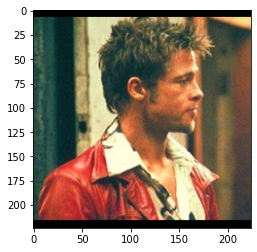

[513 593 457]
[0.8264769, 0.09290569, 0.02981044]
['cornet', 'harmonica', 'bow_tie']
________


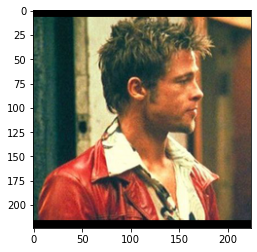

[513 593 457]
[0.85390854, 0.07418415, 0.023384077]
['cornet', 'harmonica', 'bow_tie']
________


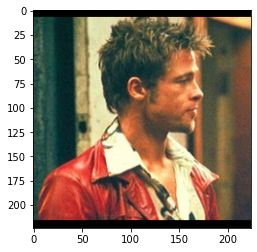

[513 593 457]
[0.767663, 0.10281222, 0.06380883]
['cornet', 'harmonica', 'bow_tie']
________


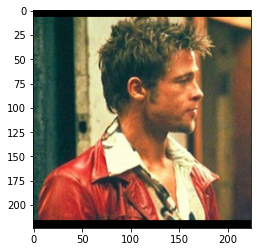

[513 457 875]
[0.7426743, 0.123026796, 0.056805015]
['cornet', 'bow_tie', 'trombone']
________


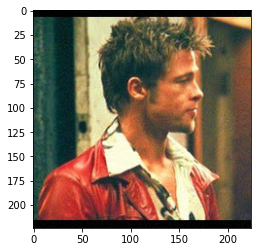

[837 457 617]
[0.44046113, 0.2078814, 0.19911692]
['sunglasses', 'bow_tie', 'lab_coat']
________


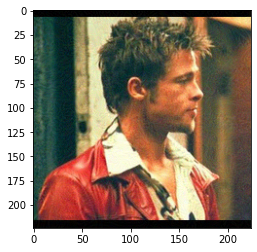

[617 457 641]
[0.19510339, 0.1752268, 0.1683649]
['lab_coat', 'bow_tie', 'maraca']
________


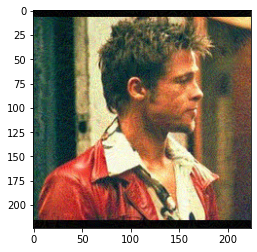

[776 845 611]
[0.28869587, 0.17200127, 0.14574024]
['sax', 'syringe', 'jigsaw_puzzle']
________


In [38]:
new_desc = []
new_cats = []
for new_adv in clipped_advs:
    pred_eps = []
    for t_im in new_adv: 
        np_im = t_im.numpy().copy()

#         plt.figure(figsize=(2,2))
        plt.figure()
        plt.imshow(np_im/255)
#         plt.imshow(utils.depreprocess(np_im)/255)
        plt.show()     
#         tranf_ims = preprocess_input(np.expand_dims(np_im, axis=0))
        new_preds = new_model.predict(np.expand_dims(np_im, axis=0))[0]
        top_args = new_preds.argsort()[-3:][::-1]
        top_desc = [class_desc_mapper[ta] for ta in top_args]
        pred_eps.append(top_args)
        print(top_args)
        print([new_preds[i] for i in top_args])
        print(top_desc)
        print('________')
   
    new_cats.append(top_args)
    new_desc.append([[class_desc_mapper[ta] for ta in tta] for tta in pred_eps])

### Run targetted attack

In [80]:
pre = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])  # RGB to BGR
fmodel: Model = TensorFlowModel(new_model, bounds=(0, 255), preprocessing=pre)
# this is in case the input images are in the interval 0..1
fmodel = fmodel.transform_bounds((0, 1)) 

In [147]:
n_attemps = 1
im_arr_orig = [utils.square_pad_image(im_ar).astype('float32') for i in range(n_attemps)]
im_arr_tf = tf.convert_to_tensor(im_arr_orig)
im_tensor = ep.astensor(im_arr_tf)
im_tensor_01 = im_tensor/255
# im_tensor_01.shape
labels_tensor = ep.astensor(tf.convert_to_tensor(np.array([1000 for i in range(n_attemps)])))


target_classes = tf.convert_to_tensor(np.random.choice(np.arange(1000), n_attemps))

In [131]:
accuracy(fmodel, im_tensor_01, labels_tensor)

1.0

In [133]:
criterion = fb.criteria.TargetedMisclassification(target_classes)
criterion

TargetedMisclassification(TensorFlowTensor(<tf.Tensor: shape=(8,), dtype=int64, numpy=array([642, 865, 470, 394, 486, 220, 335, 362])>))

In [140]:
criterion = fb.criteria.TargetedMisclassification(target_classes)
attack = fb.attacks.L2CarliniWagnerAttack(steps=1000, abort_early=False)
epsilons = None
advs, clipped_advs, is_adv = attack(fmodel, im_tensor_01, criterion, epsilons=epsilons)

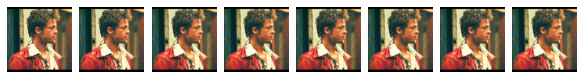

In [141]:
fb.plot.images(im_tensor_01)

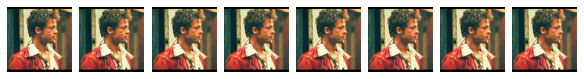

In [142]:
fb.plot.images(advs)

In [143]:
new_preds = new_model.predict(advs.numpy())
for new_p in new_preds:
    # new_preds = new_model.predict(np.expand_dims(np_im, axis=0))[0]
    top_args = new_p.argsort()[-3:][::-1]
    top_desc = [class_desc_mapper[ta] for ta in top_args]
    pred_eps.append(top_args)
    print(top_args)
    print([new_p[i] for i in top_args])
    print(top_desc)
    print('________')

[783 432 157]
[0.4665955, 0.06970183, 0.060177807]
['screw', 'bassoon', 'papillon']
________
[783 432 157]
[0.46585873, 0.06933373, 0.06035171]
['screw', 'bassoon', 'papillon']
________
[783 432 157]
[0.46789062, 0.06942231, 0.060109492]
['screw', 'bassoon', 'papillon']
________
[783 432 157]
[0.4665462, 0.06962694, 0.060184818]
['screw', 'bassoon', 'papillon']
________
[783 432 157]
[0.46733114, 0.06994869, 0.059853904]
['screw', 'bassoon', 'papillon']
________
[783 432 157]
[0.46511367, 0.07027785, 0.060610216]
['screw', 'bassoon', 'papillon']
________
[783 432 157]
[0.46010402, 0.06982005, 0.061219003]
['screw', 'bassoon', 'papillon']
________
[783 432 157]
[0.46583462, 0.06968454, 0.060254898]
['screw', 'bassoon', 'papillon']
________


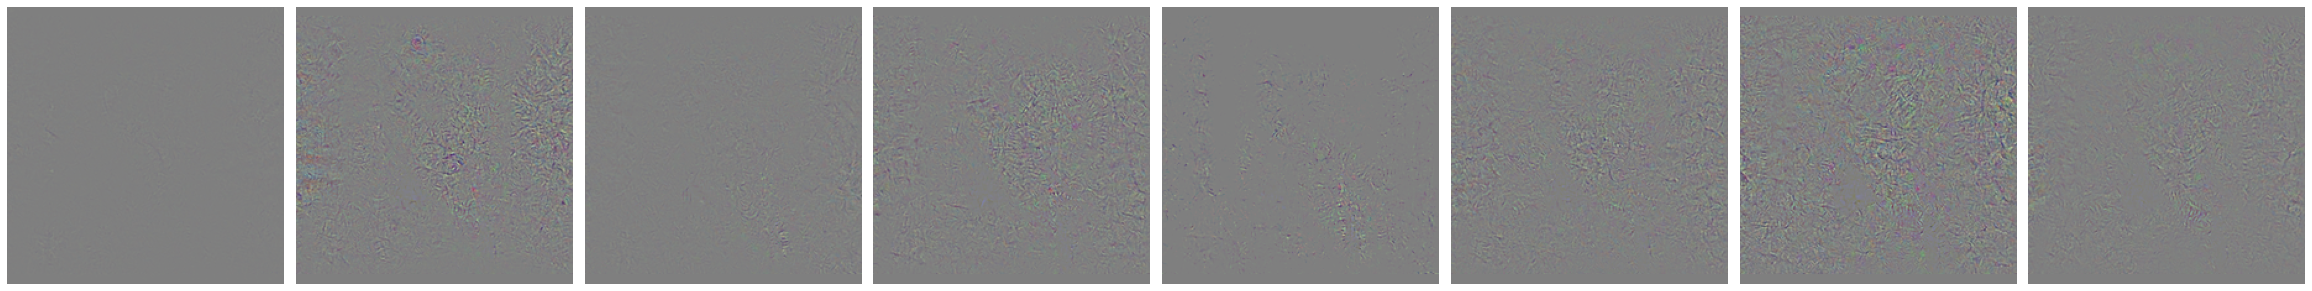

In [144]:
fb.plot.images(advs - im_tensor_01, n=n_attemps, bounds=(-0.1, 0.1), scale=4.)

### Test DNN attack
- L2DeepFoolAttack
- DDNAttack

In [250]:
target_classes = tf.convert_to_tensor(np.array([532]))
criterion = fb.criteria.TargetedMisclassification(target_classes)
attack = fb.attacks.DDNAttack(steps=1000)
epsilons = [0.0, 0.0005, 0.002, 0.1, 0.3, 1.0, 2.0, 8.0, 10., 20., 50, 255]
advs, clipped_advs, is_adv = attack(fmodel, im_tensor_01, criterion, epsilons=epsilons)

In [251]:
is_adv

TensorFlowTensor(<tf.Tensor: shape=(12, 1), dtype=bool, numpy=
                 array([[False],
                        [False],
                        [False],
                        [False],
                        [False],
                        [ True],
                        [ True],
                        [ True],
                        [ True],
                        [ True],
                        [ True],
                        [ True]])>)

In [242]:
aa = fmodel(clipped_advs[8])

In [252]:
[np.argmax(fmodel(clipped_advs[i])) for i in range(len(epsilons))]

[1000, 1000, 1000, 1000, 1000, 532, 532, 532, 532, 532, 532, 532]

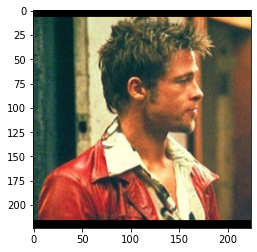

[1000  419  731]
[0.9134489, 0.0104708355, 0.008037216]
['W Bradley Pitt, aka Brad', 'Band_Aid', 'plunger']
________


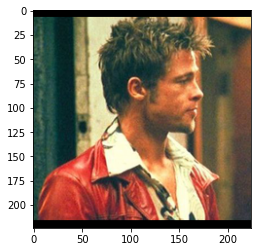

[1000  419  731]
[0.91344815, 0.010460556, 0.008038182]
['W Bradley Pitt, aka Brad', 'Band_Aid', 'plunger']
________


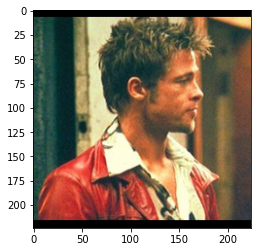

[1000  419  731]
[0.9134497, 0.010429008, 0.0080399215]
['W Bradley Pitt, aka Brad', 'Band_Aid', 'plunger']
________


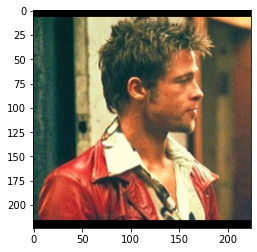

[1000  593  419]
[0.9110253, 0.010295699, 0.008410722]
['W Bradley Pitt, aka Brad', 'harmonica', 'Band_Aid']
________


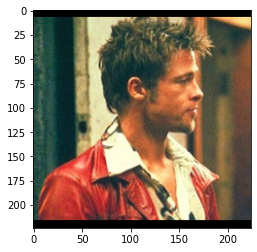

[1000  593  845]
[0.8625502, 0.03436894, 0.010443181]
['W Bradley Pitt, aka Brad', 'harmonica', 'syringe']
________


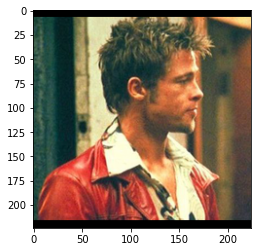

[532 845 424]
[0.12233613, 0.12195778, 0.10115168]
['dining_table', 'syringe', 'barbershop']
________


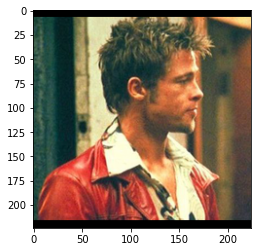

[532 845 424]
[0.12233613, 0.12195778, 0.10115168]
['dining_table', 'syringe', 'barbershop']
________


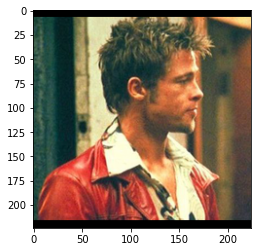

[532 845 424]
[0.12233613, 0.12195778, 0.10115168]
['dining_table', 'syringe', 'barbershop']
________


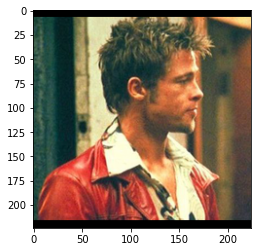

[532 845 424]
[0.12233613, 0.12195778, 0.10115168]
['dining_table', 'syringe', 'barbershop']
________


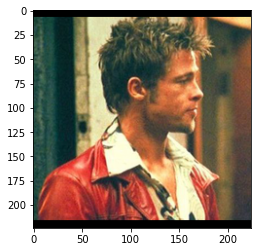

[532 845 424]
[0.12233613, 0.12195778, 0.10115168]
['dining_table', 'syringe', 'barbershop']
________


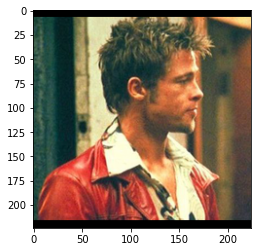

[532 845 424]
[0.12233613, 0.12195778, 0.10115168]
['dining_table', 'syringe', 'barbershop']
________


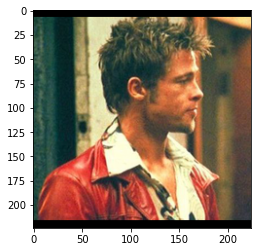

[532 845 424]
[0.12233613, 0.12195778, 0.10115168]
['dining_table', 'syringe', 'barbershop']
________


In [255]:
new_desc = []
new_cats = []
for new_adv in clipped_advs:
    pred_eps = []
    for t_im in new_adv: 
        np_im = t_im.numpy().copy()

#         plt.figure(figsize=(2,2))
        plt.figure()
        plt.imshow(np_im)
#         plt.imshow(utils.depreprocess(np_im)/255)
        plt.show()     
        tranf_ims = preprocess_input(np.expand_dims(np_im*255, axis=0))
        new_preds = new_model.predict(tranf_ims)[0]
        top_args = new_preds.argsort()[-3:][::-1]
        top_desc = [class_desc_mapper[ta] for ta in top_args]
        pred_eps.append(top_args)
        print(top_args)
        print([new_preds[i] for i in top_args])
        print(top_desc)
        print('________')
   
    new_cats.append(top_args)
    new_desc.append([[class_desc_mapper[ta] for ta in tta] for tta in pred_eps])

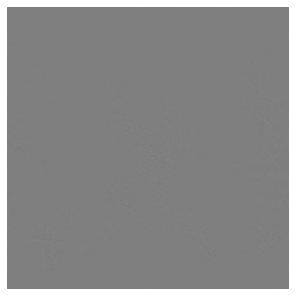

In [216]:
fb.plot.images(advs[-1] - im_tensor_01, n=1, bounds=(-0.1, 0.1), scale=4.)

In [257]:
class_desc_mapper

{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

- 29: 'axolotl',
- 107: 'jellyfish',
-  106: 'wombat',
